# Causal Discovery example on the Auto-MPG dataset



In [1]:
import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

# %R install.packages("Matching")
%R library(Matching)

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge
import networkx as nx 
# import pcalg
# from gsq.ci_tests import ci_test_bin, ci_test_dis
# from gsq.gsq_testdata import bin_data, dis_data

try:
    from urllib.request import Request, urlopen  # Python 3
except ImportError:
    from urllib2 import Request, urlopen  # Python 2

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

R[write to console]: Loading required package: MASS

R[write to console]: ## 
##  Matching (Version 4.9-9, Build Date: 2021-03-15)
##  See http://sekhon.berkeley.edu/matching for additional documentation.
##  Please cite software as:
##   Jasjeet S. Sekhon. 2011. ``Multivariate and Propensity Score Matching
##   Software with Automated Balance Optimization: The Matching package for R.''
##   Journal of Statistical Software, 42(7): 1-52. 
##


['1.19.5', '1.1.5', '0.16', '1.5.2']


## 1. Load the data

In [2]:
from cdt.data import load_dataset
data, graph = load_dataset("sachs")

# import io
# import requests
# # proxy_dict = {"https":"https://xx.xx.x.xx:80"} #replace proxy setting here

# response = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original').text
# # response = requests.get('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original', proxies=proxy_dict).text

# df = pd.read_csv(io.StringIO(response), delim_whitespace=True, header=None)


# # Auto-MPG
# req = Request('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original')
# req.add_header('User-Agent', 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
# content = urlopen(req)
# data = pd.read_csv(content,
#                    delim_whitespace=True, header=None,
                #    names = ['mpg', 'cylinders', 'displacement',
                #             'horsepower', 'weight', 'acceleration',
                #             'model year', 'origin', 'car name'])
# data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
#                    delim_whitespace=True, header=None,
#                    names = ['mpg', 'cylinders', 'displacement',
#                             'horsepower', 'weight', 'acceleration',
#                             'model year', 'origin', 'car name'])
data.dropna(inplace=True)
# data.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)
# data.drop(['p44/42', 'PKC', 'PKA', 'praf'], axis=1, inplace=True)
# data = data[:346]
print(data.shape)
data.head()

No GPU automatically detected. Setting SETTINGS.GPU to 0, and SETTINGS.NJOBS to cpu_count.
(7466, 11)


,praf,pmek,plcg,PIP2,PIP3,p44/42,pakts473,PKA,PKC,P38,pjnk
0,26.4,13.2,8.82,18.30,58.80,6.61,17.0,414.0,17.00,44.9,40.0
1,35.9,16.5,12.30,16.80,8.13,18.60,32.5,352.0,3.37,16.5,61.5
2,59.4,44.1,14.60,10.20,13.00,14.90,32.5,403.0,11.40,31.9,19.5
3,73.0,82.8,23.10,13.50,1.29,5.83,11.8,528.0,13.70,28.6,23.1
4,33.7,19.8,5.19,9.73,24.80,21.10,46.1,305.0,4.66,25.7,81.3


## Utility function
We define a utility function to draw the directed acyclic graph.

In [3]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    # print(adjacency_matrix[idx])
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        # print(names[from_], names[to], str(coef))
        d.edge(names[from_], names[to], label=str(coef))
        # d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

def str_to_dot(string):
    '''
    Converts input string to valid DOT graph format
    '''
    graph = string.replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1]
    return graph

# Causal Discovery

To run causal discovery, we create a DirectLiNGAM object and call the fit method.

In [6]:
graphs = {}
labels = [f'{col}' for i, col in enumerate(data.columns)]

# # DirectLiNGAM
# pk = make_prior_knowledge(
#     n_variables=len(data.columns),
#     sink_variables=[4])
# model = lingam.DirectLiNGAM(prior_knowledge=pk)
# model.fit(data)
# graph_dot = make_graph(model.adjacency_matrix_, labels)
# graphs['DirectLiNGAM'] = graph_dot

# DirectLiNGAM by Kernel Method
model = lingam.DirectLiNGAM(measure='kernel')
model.fit(data)
# print(model.adjacency_matrix_)
# print(model.adjacency_matrix_.shape)
# print(labels)
if type(model.adjacency_matrix_) is np.ndarray:
    print("YES")
graph_dot = make_graph(model.adjacency_matrix_, labels)
graphs['DirectLiNGAM by Kernel Method'] = graph_dot

# # ICALiNGAM
# model = lingam.ICALiNGAM()
# model.fit(data)
# graph_dot = make_graph(model.adjacency_matrix_, labels)
# graphs['ICALiNGAM'] = graph_dot

# # BottomUpParceLiNGAM
# prior_knowledge = make_prior_knowledge(
#     n_variables=len(data.columns),
#     sink_variables=[4])
# model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
# model.fit(data)
# graph_dot = make_graph(model.adjacency_matrix_, labels)
# graphs['BottomUpParceLiNGAM'] = graph_dot

# # PC Algorithm
# dm = np.array(bin_data).reshape((5000, 5))
# dm = np.array(data.to_numpy()).astype('int')
# print(dm.shape)
# print(data.shape)
# (g, sep_set) = pcalg.estimate_skeleton(indep_test_func=ci_test_bin, data_matrix=dm, alpha=0.01)
# g = pcalg.estimate_cpdag(skel_graph=g, sep_set=sep_set)
# adjacency_matrix = nx.to_numpy_matrix(g)
# print(adjacency_matrix.shape)

# Visualize graphs
for method, graph in graphs.items():
    print("Method : %s"%(method))
    display(graph)

KeyboardInterrupt: 

# Causal Discovery with Causal Discovery Tool (CDT)

Method : LiNGAM


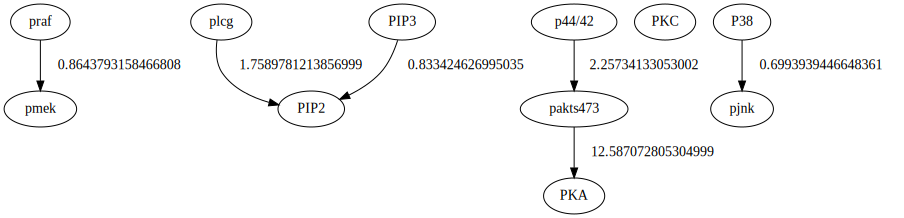

Method : PC


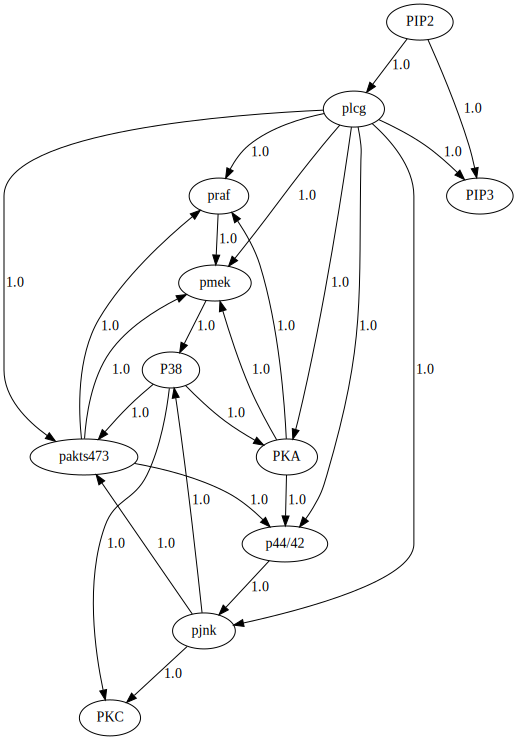

Method : GES


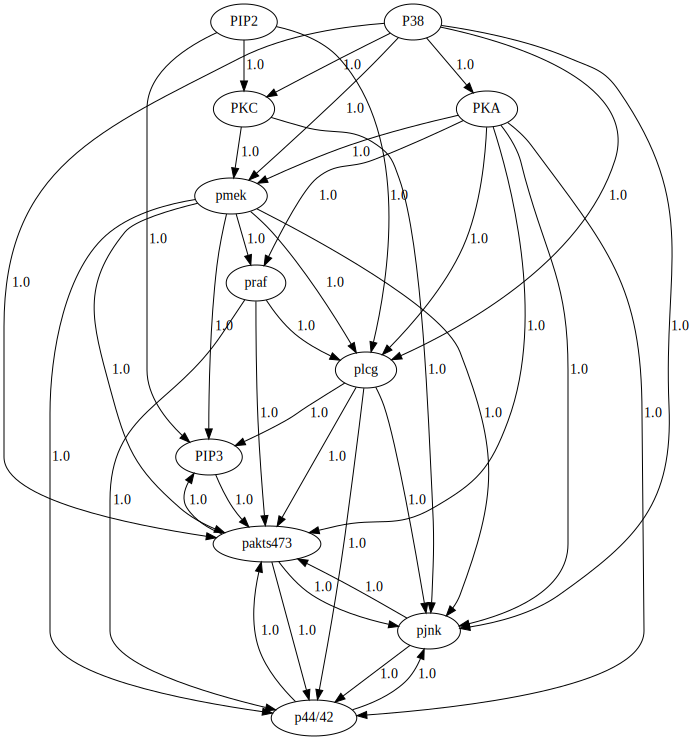

Method : GIES


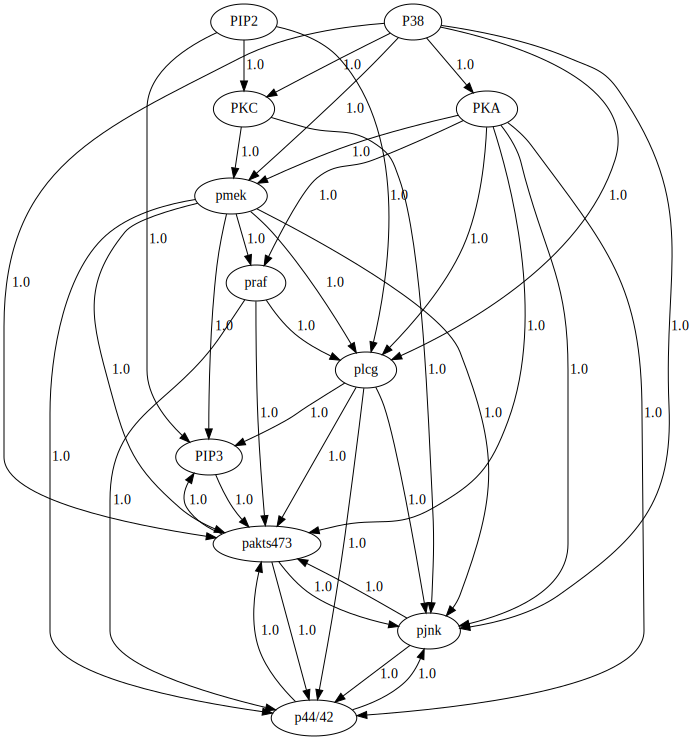

In [5]:
graphs_cdt = {}
labels = [f'{col}' for i, col in enumerate(data.columns)]

# LiNGAM
from cdt.causality.graph import LiNGAM
obj = LiNGAM()
output = obj.predict(data)
adj_matrix = nx.to_numpy_matrix(output)
adj_matrix = np.asarray(adj_matrix)
graph_dot_cdt = make_graph(adj_matrix, labels)
graphs_cdt['LiNGAM'] = graph_dot_cdt

# PC Algorithm
from cdt.causality.graph import PC
obj = PC()
output = obj.predict(data)    #No graph provided as an argument
# output = obj.predict(data, nx.Graph(graph))  #With an undirected graph
# output = obj.predict(data, graph)  #With a directed graph
adj_matrix = nx.to_numpy_matrix(output)
adj_matrix = np.asarray(adj_matrix)
graph_dot_cdt = make_graph(adj_matrix, labels)
graphs_cdt['PC'] = graph_dot_cdt

# GES Algorithm
from cdt.causality.graph import GES
obj = GES()
output = obj.predict(data)    #No graph provided as an argument
# output = obj.predict(data, nx.Graph(graph))  #With an undirected graph
# output = obj.predict(data, graph)  #With a directed graph
adj_matrix = nx.to_numpy_matrix(output)
adj_matrix = np.asarray(adj_matrix)
graph_dot_cdt = make_graph(adj_matrix, labels)
graphs_cdt['GES'] = graph_dot_cdt

# GIES Algorithm
from cdt.causality.graph import GIES
obj = GIES()
output = obj.predict(data)    #No graph provided as an argument
# output = obj.predict(data, nx.Graph(graph))  #With an undirected graph
# output = obj.predict(data, graph)  #With a directed graph
adj_matrix = nx.to_numpy_matrix(output)
adj_matrix = np.asarray(adj_matrix)
graph_dot_cdt = make_graph(adj_matrix, labels)
graphs_cdt['GIES'] = graph_dot_cdt

# # CGNN Algorithm
# from cdt.causality.graph import CGNN
# obj = CGNN()
# # output = obj.predict(data)    #No graph provided as an argument
# output = obj.predict(data, nx.Graph(graph))  #With an undirected graph
# # output = obj.predict(data, graph)  #With a directed graph
# adj_matrix = nx.to_numpy_matrix(output)
# adj_matrix = np.asarray(adj_matrix)
# graph_dot_cdt = make_graph(adj_matrix, labels)
# graphs_cdt['CGNN'] = graph_dot_cdt

# # FSGNN
# from cdt.independence.graph import FSGNN
# Fsgnn = FSGNN(train_epochs=1000, test_epochs=500, l1=0.1, batch_size=1000)
# output = Fsgnn.predict(data, threshold=1e-7)
# adj_matrix = nx.to_numpy_matrix(output)
# adj_matrix = np.asarray(adj_matrix)
# graph_dot_cdt = make_graph(adj_matrix, labels)
# graphs_cdt['FSGNN'] = graph_dot_cdt

# # Visualize graphs
for method, graph in graphs_cdt.items():
    print("Method : %s"%(method))
    display(graph)
    # graph.render(method + '.png', view=True)

## Estimate effects using Linear Regression

In [7]:
for method, graph in graphs.items():
        print('\n*****************************************************************************\n')
        print("Causal Discovery Method : %s"%(method))

        # Obtain valid dot format
        graph = str_to_dot(graph.source)

        # Define Causal Model
        model=CausalModel(
                data = data,
                treatment='mpg',
                outcome='weight',
                graph=graph)

        # Identification
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimation
        estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1,
                                        confidence_intervals=True,
                                        test_significance=True)
        print(estimate)
        print("Causal Estimate is " + str(estimate.value))


*****************************************************************************

Causal Discovery Method : DirectLiNGAM
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                  
──────(Expectation(weight|cylinders))
d[mpg]                               
Estimand assumption 1, Unconfoundedness: If U→{mpg} and U→weight then P(weight|mpg,cylinders,U) = P(weight|mpg,cylinders)

## Realized estimand
b: weight~mpg+cylinders
Target units: ate

## Estimate
Mean value: -36.97546905326499
p-value: [0.]
95.0% confidence interval: [[-43.631 -30.319]]

Causal Estimate is -36.97546905326499


## Estimate effects using Double ML

In [12]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

for method, graph in graphs.items():
        print('\n*****************************************************************************\n')
        print("Causal Discovery Method : %s"%(method))

        # Obtain valid dot format
        graph = str_to_dot(graph.source)

        # Define Causal Model
        model=CausalModel(
                data = data,
                treatment='mpg',
                outcome='weight',
                graph=graph)

        # Identification
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimation
        # dml_estimate = model.estimate_effect(identified_estimand, 
        #                                     method_name="backdoor.econml.dml.DML",
        #                                     method_params={
        #                                         'init_params': {'model_y':LassoCV(fit_intercept=False),
        #                                                         'model_t': LassoCV(fit_intercept=False),
        #                                                         'model_final':LassoCV(fit_intercept=False), },
        #                                         'fit_params': {}
        #                                     })
        
        dml_estimate = model.estimate_effect(identified_estimand, 
                                            method_name="backdoor.econml.dml.DML",
                                            method_params={
                                                'init_params': {'model_y':GradientBoostingRegressor(),
                                                                'model_t': GradientBoostingRegressor(),
                                                                'model_final':LassoCV(fit_intercept=False), },
                                                'fit_params': {}
                                            })
        print(dml_estimate)
        print("Causal Estimate is " + str(dml_estimate.value))


*****************************************************************************

Causal Discovery Method : DirectLiNGAM


AttributeError: 'numpy.ndarray' object has no attribute 'columns'